In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import torch
import numpy as np
import matplotlib.pyplot as plt
from balanced_loss import Loss
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# from transformers import AutoTokenizer, AutoModel
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

from data.constants import LOCAL_MODELS_PATH, CHECKPOINTS_PATH, TRAIN_DF_PATH, VALID_DF_PATH, TEST_DF_PATH


BASE_MODEL_PATH = LOCAL_MODELS_PATH / 't5-small'
MAX_LEN = 512
batch_size = 8
TRAIN_BATCH_SIZE = batch_size
VALID_BATCH_SIZE = batch_size
TEST_BATCH_SIZE = batch_size

LIMIT_NUM_MODELS = 2

SEED = 2
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 2e-5
N_EPOCHS = 15
PATIENCE = 3

model_name = BASE_MODEL_PATH.name
CHECKPOINTS_DIR = CHECKPOINTS_PATH / model_name / 'checkpoints_train_v2'
CHECKPOINTS_DIR.mkdir(exist_ok=True, parents=True)
MODEL_TO_SAVE_TEMPLE = 'model-{epoch}-epoch.pt'

In [2]:
df_train = pd.read_parquet(TRAIN_DF_PATH)
df_valid = pd.read_parquet(VALID_DF_PATH)
df_test = pd.read_parquet(TEST_DF_PATH)

In [3]:
# Проверка доступности GPU
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))

# Указание устройства
DEVICE = torch.device("cuda:0")  # Используем первую видеокарту (индекс 0)

CUDA Available: True
Number of GPUs: 1
Current GPU: NVIDIA GeForce GTX 1650


In [4]:
class ProteinSeqSmailesDataset(Dataset):
    def __init__(self, df, tokenizer_path, input_column, output_column, max_len):
        self.max_len = max_len
        self.df = df
        self.input_column = input_column
        self.output_column = output_column
        self.tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]

        inputs = self.tokenizer.encode_plus(
            row[self.input_column],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )

        labels = self.tokenizer.encode_plus(
            row[self.output_column],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
    
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': labels['input_ids'].flatten(),
        }

train_dataset = ProteinSeqSmailesDataset(df_train, BASE_MODEL_PATH, 'Target', 'Drug', MAX_LEN)
valid_dataset = ProteinSeqSmailesDataset(df_valid, BASE_MODEL_PATH, 'Target', 'Drug', MAX_LEN)
test_dataset = ProteinSeqSmailesDataset(df_test, BASE_MODEL_PATH, 'Target', 'Drug', MAX_LEN)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, generator=torch.manual_seed(SEED), num_workers=0, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, generator=torch.manual_seed(SEED), num_workers=0, shuffle=True, pin_memory=True)

In [6]:
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_PATH)
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

In [7]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.9,
    patience=2,
    )

loss_status = {
    'train': [],
    'valid': []
}
min_valid_loss = float('inf')
epochs_without_improvement = 0
saved_models_path = []

In [8]:
initial_data_size = 4500  # Начальное количество строк
data_increment_step = 1000  # Шаг увеличения данных
current_data_size = initial_data_size  # Текущее количество строк для обучения

In [9]:
for epoch in range(N_EPOCHS):
    subset_indices = list(range(current_data_size))
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)

    train_loader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        sampler=subset_sampler,
        num_workers=0,
        pin_memory=True
    )

    print(f"Epoch {epoch + 1}: Training on {current_data_size} samples")

    train_losses = []

    model.train()
    for i, batch in enumerate(tqdm(train_loader, 'Train')):
        optimizer.zero_grad()

        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        labels = batch['labels']
        del batch['labels']

        outputs = model(**batch, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader, 'Valid')):
            batch = {key: value.to(DEVICE) for key, value in batch.items()}
            labels = batch['labels']
            del batch['labels']

            outputs = model(**batch, labels=labels)
            loss = outputs.loss

            valid_losses.append(loss.item())

    loss_status['train'].append(np.mean(train_losses))
    loss_status['valid'].append(np.mean(valid_losses))

    scheduler.step(loss_status['valid'][-1])

    if loss_status["valid"][-1] < min_valid_loss:
        min_valid_loss = loss_status["valid"][-1]
        epochs_without_improvement = 0

        model_name = CHECKPOINTS_DIR / MODEL_TO_SAVE_TEMPLE.format(epoch=epoch)
        torch.save(model.state_dict(), str(model_name))

        saved_models_path.append(model_name)
        if len(saved_models_path) > LIMIT_NUM_MODELS:
            model_to_del = saved_models_path[0]
            model_to_del.unlink()
            del saved_models_path[0]
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= PATIENCE:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

    current_data_size += data_increment_step
    current_data_size = min(current_data_size, len(train_dataset))  # Не превышаем общее количество данных

    print(f"{'EPOCH: ' + str(epoch):-^50}")
    print(f"Loss:")
    print(f"  Train: {loss_status['train'][-1]:.5f}")
    print(f"  Valid: {loss_status['valid'][-1]:.5f}")
    print("-" * 50, end="\n\n")

Epoch 1: Training on 4500 samples


Train:   0%|          | 0/563 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Valid: 100%|██████████| 63/63 [05:24<00:00,  5.15s/it]


---------------------EPOCH: 0---------------------
Loss:
  Train: 1.20951
  Valid: 0.35877
--------------------------------------------------

Epoch 2: Training on 5500 samples


Valid: 100%|██████████| 63/63 [05:12<00:00,  4.96s/it]


---------------------EPOCH: 1---------------------
Loss:
  Train: 0.34949
  Valid: 0.25572
--------------------------------------------------

Epoch 3: Training on 6500 samples


Valid: 100%|██████████| 63/63 [05:54<00:00,  5.62s/it]


---------------------EPOCH: 2---------------------
Loss:
  Train: 0.25455
  Valid: 0.19542
--------------------------------------------------

Epoch 4: Training on 7500 samples


Valid: 100%|██████████| 63/63 [05:47<00:00,  5.52s/it]


---------------------EPOCH: 3---------------------
Loss:
  Train: 0.20982
  Valid: 0.17220
--------------------------------------------------

Epoch 5: Training on 8500 samples


Valid: 100%|██████████| 63/63 [05:16<00:00,  5.03s/it]


---------------------EPOCH: 4---------------------
Loss:
  Train: 0.18179
  Valid: 0.15458
--------------------------------------------------

Epoch 6: Training on 9500 samples


Valid: 100%|██████████| 63/63 [05:41<00:00,  5.43s/it]


---------------------EPOCH: 5---------------------
Loss:
  Train: 0.16725
  Valid: 0.14079
--------------------------------------------------

Epoch 7: Training on 10500 samples


Valid: 100%|██████████| 63/63 [05:49<00:00,  5.55s/it]


---------------------EPOCH: 6---------------------
Loss:
  Train: 0.15778
  Valid: 0.12949
--------------------------------------------------

Epoch 8: Training on 11500 samples


Valid: 100%|██████████| 63/63 [05:14<00:00,  4.99s/it]


---------------------EPOCH: 7---------------------
Loss:
  Train: 0.14577
  Valid: 0.12129
--------------------------------------------------

Epoch 9: Training on 12500 samples


Valid: 100%|██████████| 63/63 [05:34<00:00,  5.31s/it]


---------------------EPOCH: 8---------------------
Loss:
  Train: 0.13487
  Valid: 0.11471
--------------------------------------------------

Epoch 10: Training on 13500 samples


Valid: 100%|██████████| 63/63 [05:33<00:00,  5.29s/it]


---------------------EPOCH: 9---------------------
Loss:
  Train: 0.12490
  Valid: 0.10993
--------------------------------------------------

Epoch 11: Training on 14500 samples


Valid: 100%|██████████| 63/63 [05:06<00:00,  4.86s/it]


--------------------EPOCH: 10---------------------
Loss:
  Train: 0.11658
  Valid: 0.10413
--------------------------------------------------

Epoch 12: Training on 15500 samples


Valid: 100%|██████████| 63/63 [05:47<00:00,  5.52s/it]


--------------------EPOCH: 11---------------------
Loss:
  Train: 0.10804
  Valid: 0.10063
--------------------------------------------------

Epoch 13: Training on 16500 samples


Valid: 100%|██████████| 63/63 [05:48<00:00,  5.54s/it]


--------------------EPOCH: 12---------------------
Loss:
  Train: 0.09979
  Valid: 0.09745
--------------------------------------------------

Epoch 14: Training on 17500 samples


Valid: 100%|██████████| 63/63 [05:12<00:00,  4.97s/it]


--------------------EPOCH: 13---------------------
Loss:
  Train: 0.09369
  Valid: 0.09605
--------------------------------------------------

Epoch 15: Training on 18500 samples


Valid: 100%|██████████| 63/63 [05:37<00:00,  5.36s/it]


--------------------EPOCH: 14---------------------
Loss:
  Train: 0.09133
  Valid: 0.09177
--------------------------------------------------



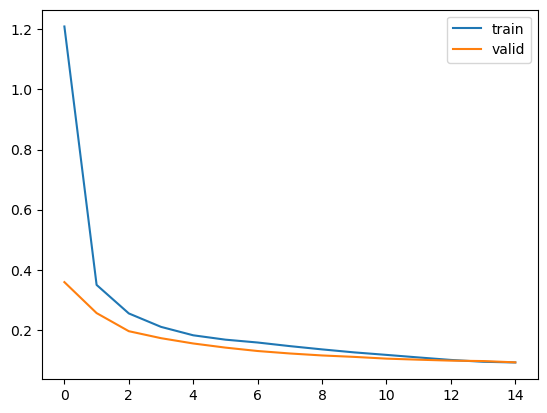

In [10]:
plt.plot(loss_status['train'], label='train')
plt.plot(loss_status['valid'], label='valid')
plt.legend()
plt.show()


In [11]:
def evaluate_test_loss(model, data_loader, device):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for batch in tqdm(data_loader, "Test"):
            batch = {key: value.to(device) for key, value in batch.items()}
            labels = batch["labels"]
            del batch["labels"]

            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            test_losses.append(loss.item())

    return np.mean(test_losses)

test_loss = evaluate_test_loss(model, test_loader, DEVICE)
print(f"Test Loss: {test_loss:.4f}")

Test: 100%|██████████| 125/125 [10:46<00:00,  5.17s/it]

Test Loss: 0.0924
